
# End-to-End Regression: Predicting House Rent in Indian Cities

This notebook walks through a complete machine learning workflow using a real Indian rental housing dataset.

**Goal:** Predict monthly rent using housing attributes.  
**Focus:** Practical ML workflow, not mathematical depth.  
**Style:** Clean steps, clear reasoning, reusable code.



## 1. Load the data

We begin by loading the dataset and taking a first look at its structure.


In [2]:

import pandas as pd

df = pd.read_csv("data/cities_magicbricks_rental_prices.csv")
df.head()


,house_type,locality,city,area,beds,bathrooms,balconies,furnishing,area_rate,rent
0,"2 BHK Flat for Rent in Oberoi Woods, Goregaon ...",Goregaon East,Mumbai,897.0,2,2,0,Semi-Furnished,134.0,120000.0
1,"1 BHK Flat for Rent in Sapphire Lakeside, Powa...",Powai,Mumbai,490.0,1,1,0,Semi-Furnished,82.0,40000.0
2,1 BHK House for Rent in Mundhwa Pune,Mundhwa,Pune,550.0,1,1,0,Unfurnished,22.0,12000.0
3,"2 BHK Flat for Rent in Hingna, Nagpur",Hingna,Nagpur,1000.0,2,2,0,Unfurnished,8.0,8000.0
4,1 BHK Flat for Rent in Unique Star Harsh Vihar...,Mira Road,Mumbai,595.0,1,1,0,Unfurnished,25.0,15000.0



## 2. Understand the data

We inspect the schema, data types, and basic statistics.
This helps identify missing values and feature types.


In [3]:

df.info()


<class 'pandas.DataFrame'>
RangeIndex: 7691 entries, 0 to 7690
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   house_type  7691 non-null   str    
 1   locality    7691 non-null   str    
 2   city        7691 non-null   str    
 3   area        7691 non-null   float64
 4   beds        7691 non-null   int64  
 5   bathrooms   7691 non-null   int64  
 6   balconies   7691 non-null   int64  
 7   furnishing  7691 non-null   str    
 8   area_rate   7691 non-null   float64
 9   rent        7691 non-null   float64
dtypes: float64(3), int64(3), str(4)
memory usage: 601.0 KB


In [4]:

df.describe()


,area,beds,bathrooms,balconies,area_rate,rent
count,7691.000000,7691.000000,7691.000000,7691.000000,7691.000000,7.691000e+03
mean,1106.354180,2.208685,2.137043,0.817319,47.619989,5.479508e+04
std,1197.426843,0.993481,1.027677,1.243361,68.989657,9.742006e+04
min,2.000000,1.000000,0.000000,0.000000,2.000000,1.000000e+03
25%,600.000000,1.000000,1.000000,0.000000,21.000000,1.500000e+04
50%,900.000000,2.000000,2.000000,0.000000,31.000000,2.800000e+04
75%,1300.000000,3.000000,3.000000,2.000000,54.000000,5.700000e+04
max,70000.000000,10.000000,10.000000,10.000000,2586.000000,2.700000e+06



We also inspect categorical distributions to understand location and furnishing patterns.


In [5]:

df["city"].value_counts()


city
New Delhi    1808
Bangalore    1790
Pune         1779
Mumbai       1719
Nagpur        595
Name: count, dtype: int64

In [ ]:

df["furnishing"].value_counts()



## 3. Define the machine learning task

- **Target:** `rent` (continuous value)
- **Type:** Supervised regression problem


In [6]:

X = df.drop("rent", axis=1)
y = df["rent"]



## 4. Train–test split

We separate data into training and test sets.
The test set simulates unseen future data.


In [8]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



## 5. Exploratory Data Analysis (EDA)

We explore key relationships using simple visualizations.


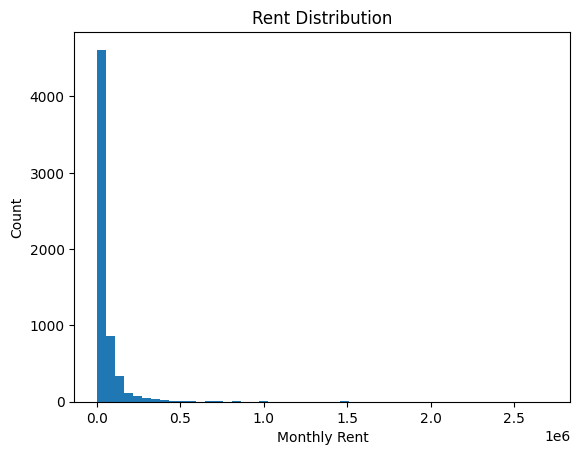

In [9]:

import matplotlib.pyplot as plt

plt.hist(y_train, bins=50)
plt.xlabel("Monthly Rent")
plt.ylabel("Count")
plt.title("Rent Distribution")
plt.show()


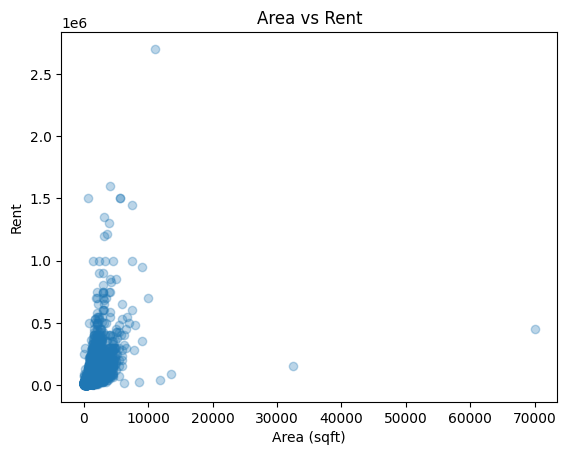

In [10]:

plt.scatter(df["area"], df["rent"], alpha=0.3)
plt.xlabel("Area (sqft)")
plt.ylabel("Rent")
plt.title("Area vs Rent")
plt.show()



## 6. Correlation analysis

We check numeric correlations to build intuition.


In [11]:

numeric_cols = ["area", "beds", "bathrooms", "balconies", "area_rate"]
df[numeric_cols + ["rent"]].corr()["rent"].sort_values(ascending=False)


rent         1.000000
bathrooms    0.532681
area_rate    0.507104
beds         0.473695
area         0.433513
balconies    0.179181
Name: rent, dtype: float64


## 7. Feature selection

We keep clean, interpretable features.
Free-text columns are excluded for simplicity.


In [12]:

num_features = ["area", "beds", "bathrooms", "balconies", "area_rate"]
cat_features = ["city", "furnishing"]

X_train = X_train[num_features + cat_features]
X_test = X_test[num_features + cat_features]



## 8. Preprocessing pipelines

We prepare numeric and categorical features separately.
This prevents data leakage and keeps transformations reusable.


In [13]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])



## 9. Model training

We train three regression models using the same preprocessing pipeline.


In [14]:

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "DecisionTree": DecisionTreeRegressor(random_state=42)
}


In [15]:

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    results[name] = {"RMSE": rmse, "R2": r2}

results


{'LinearRegression': {'RMSE': np.float64(60859.823186592046),
  'R2': 0.5057564003780697},
 'Ridge': {'RMSE': np.float64(60861.39922091927), 'R2': 0.5057308020465576},
 'DecisionTree': {'RMSE': np.float64(37312.60546627991),
  'R2': 0.8142234756643987}}


## 10. Error analysis

We inspect where predictions fail the most.


In [16]:

best_model = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

errors = X_test.copy()
errors["actual_rent"] = y_test
errors["predicted_rent"] = preds
errors["abs_error"] = abs(errors["actual_rent"] - errors["predicted_rent"])

errors.sort_values("abs_error", ascending=False).head(10)


,area,beds,bathrooms,balconies,area_rate,city,furnishing,actual_rent,predicted_rent,abs_error
6163,100.0,2,1,0,2500.0,New Delhi,Unfurnished,250000.0,1.560613e+06,1.310613e+06
6834,3100.0,4,5,0,387.0,Mumbai,Unfurnished,1200000.0,4.164373e+05,7.835627e+05
7238,7500.0,4,5,0,133.0,Bangalore,Furnished,1000000.0,3.195137e+05,6.804863e+05
1253,2300.0,4,3,3,435.0,Mumbai,Furnished,1000000.0,3.832384e+05,6.167616e+05
4122,3000.0,5,5,0,298.0,Mumbai,Semi-Furnished,900000.0,3.694737e+05,5.305263e+05
3260,3042.0,5,6,0,247.0,Mumbai,Semi-Furnished,750000.0,3.613365e+05,3.886635e+05
7023,2950.0,3,4,0,203.0,Mumbai,Unfurnished,600000.0,2.620602e+05,3.379398e+05
5602,4000.0,4,4,5,138.0,New Delhi,Semi-Furnished,550000.0,2.197556e+05,3.302444e+05
3406,3200.0,4,5,2,188.0,Mumbai,Semi-Furnished,600000.0,2.874860e+05,3.125140e+05
5938,2800.0,3,4,0,196.0,Mumbai,Unfurnished,550000.0,2.546948e+05,2.953052e+05



## 11. Wrap-up

- We walked through an end-to-end regression workflow.
- The same structure applies to many ML problems.
- Classification follows a similar pipeline with different targets and metrics.

**Next steps:**
- Cross-validation
- Better models (Random Forest, Gradient Boosting)
- Feature engineering
